# Project: Tom vs. Tom - Investigating TMDB Dataset


## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

### Goal
This investigation will take a look at the two Tom's (Cruise v. Hanks) in Hollywood to find out:
1. Who's the more productive Tom? (most number of films)
2. Who's the more romantic Tom? (most number/procentage of films with romantic tags)
3. Who's the more bankable Tom? (highest average revenue)

<a id='intro'></a>
## Introduction

Each row of this TMDB dataset generally contains 21 parameters as shown below.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

df = pd.read_csv('movies.csv')
df.head(1)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09


In total there are 10866 rows in this dataset, however, not every row has all the 21 parameters. The next section "Data Wrangling" will take a look at the selected data, and try see if there are the incomplete rows.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

### Quick glance at Top 100 "Blockbusters"
As the last part of the introduction section, we want to quickly take a look at the revenues of the 100 most profitable films in the database, to get an idea of what qualifies as a blockbuster film in the industry. 

We can do this by order the rows by "revenue_adj" at plot the values from the top 100 rows.

In [17]:
df_top100 = df.sort_values(by=['revenue_adj'], ascending=False).head(100).reset_index()

df_top100.head(5) # see the top 5 blockbusters

,index,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,1386,19995,tt0499549,9.432768,237000000,2781505847,Avatar,Sam Worthington|Zoe Saldana|Sigourney Weaver|S...,http://www.avatarmovie.com/,James Cameron,...,"In the 22nd century, a paraplegic Marine is di...",162,Action|Adventure|Fantasy|Science Fiction,Ingenious Film Partners|Twentieth Century Fox ...,12/10/09,8458,7.1,2009,2.408869e+08,2.827124e+09
1,1329,11,tt0076759,12.037933,11000000,775398007,Star Wars,Mark Hamill|Harrison Ford|Carrie Fisher|Peter ...,http://www.starwars.com/films/star-wars-episod...,George Lucas,...,Princess Leia is captured and held hostage by ...,121,Adventure|Action|Science Fiction,Lucasfilm|Twentieth Century Fox Film Corporation,3/20/77,4428,7.9,1977,3.957559e+07,2.789712e+09
2,5231,597,tt0120338,4.355219,200000000,1845034188,Titanic,Kate Winslet|Leonardo DiCaprio|Frances Fisher|...,http://www.titanicmovie.com/menu.html,James Cameron,...,"84 years later, a 101-year-old woman named Ros...",194,Drama|Romance|Thriller,Paramount Pictures|Twentieth Century Fox Film ...,11/18/97,4654,7.3,1997,2.716921e+08,2.506406e+09
3,10594,9552,tt0070047,2.010733,8000000,441306145,The Exorcist,Linda Blair|Max von Sydow|Ellen Burstyn|Jason ...,http://theexorcist.warnerbros.com/,William Friedkin,...,12-year-old Regan MacNeil begins to adapt an e...,122,Drama|Horror|Thriller,Warner Bros.|Hoya Productions,12/26/73,1113,7.2,1973,3.928928e+07,2.167325e+09
4,9806,578,tt0073195,2.563191,7000000,470654000,Jaws,Roy Scheider|Robert Shaw|Richard Dreyfuss|Lorr...,http://www.jaws25.com/,Steven Spielberg,...,An insatiable great white shark terrorizes the...,124,Horror|Thriller|Adventure,Universal Pictures|Zanuck/Brown Productions,6/18/75,1415,7.3,1975,2.836275e+07,1.907006e+09


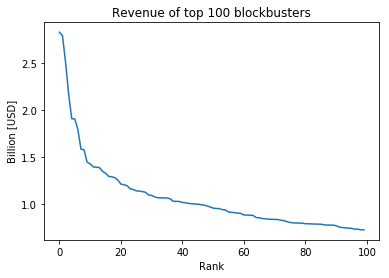

In [23]:
plt.plot(df_top100.index, df_top100['revenue_adj']/1E9)
plt.ylabel("Billion [USD]")
plt.xlabel("Rank")
plt.title('Revenue of top 100 blockbusters')
plt.show()

<a id='wrangling'></a>
## Data Wrangling

At the beginning of this section, I use a function to extract the rows concerning the specific actor.

In [25]:
df_temp = df.dropna(subset=["cast"])
def actor_search(name):
    return df_temp[df_temp['cast'].str.contains(name)] 

df_cruise = actor_search("Tom Cruise")
df_hanks = actor_search("Tom Hanks")

In [26]:
df_hanks

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
33,296098,tt3682448,3.648210,40000000,162610473,Bridge of Spies,Tom Hanks|Mark Rylance|Amy Ryan|Alan Alda|Seba...,NaN,Steven Spielberg,"In the shadow of war, one man showed the world...",...,"During the Cold War, the Soviet Union captures...",141,Thriller|Drama,DreamWorks SKG|Amblin Entertainment|Studio Bab...,10/15/15,1638,7.1,2015,3.679998e+07,1.496016e+08
825,256835,tt3473654,0.707208,0,0,Toy Story That Time Forgot,Tom Hanks|Tim Allen|Joan Cusack|Kristen Schaal...,NaN,Steve Purcell,NaN,...,"During a post-Christmas play date, the gang fi...",22,Animation|Family,Pixar Animation Studios,12/2/14,169,6.9,2014,0.000000e+00,0.000000e+00
1401,13448,tt0808151,2.841562,150000000,356613439,Angels & Demons,Tom Hanks|Ewan McGregor|Ayelet Zurer|Stellan S...,http://www.angelsanddemons.com/,Ron Howard,The holiest event of our time. Perfect for the...,...,Harvard symbologist Robert Langdon investigate...,138,Thriller|Mystery,Columbia Pictures|Imagine Entertainment|Panora...,5/13/09,1275,6.3,2009,1.524601e+08,3.624621e+08
1930,10193,tt0435761,2.711136,200000000,1063171911,Toy Story 3,Tom Hanks|Tim Allen|Ned Beatty|Joan Cusack|Mic...,http://disney.go.com/toystory/,Lee Unkrich,No toy gets left behind.,...,"Woody, Buzz, and the rest of Andy's toys haven...",103,Animation|Family|Comedy,Walt Disney Pictures|Pixar Animation Studios,6/16/10,2924,7.5,2010,2.000000e+08,1.063172e+09
2414,497,tt0120689,2.719461,60000000,284600000,The Green Mile,Tom Hanks|Michael Clarke Duncan|David Morse|Bo...,http://thegreenmile.warnerbros.com/,Frank Darabont,Miracles do happen.,...,A supernatural tale set on death row in a Sout...,189,Fantasy|Drama|Crime,Castle Rock Entertainment|Darkwoods Production...,12/10/99,2299,8.0,1999,7.854317e+07,3.725564e+08
2422,863,tt0120363,1.810197,90000000,485015179,Toy Story 2,Tom Hanks|Tim Allen|Kelsey Grammer|Joan Cusack...,http://toystory.disney.com/toy-story-2,John Lasseter|Lee Unkrich|Ash Brannon,The toys are back!,...,During a garage sale Andyâ€™s mother sells som...,92,Animation|Comedy|Family,Walt Disney Pictures|Pixar Animation Studios,10/30/99,2272,7.2,1999,1.178148e+08,6.349105e+08
3439,59861,tt1583420,1.215505,30000000,36160375,Larry Crowne,Tom Hanks|Julia Roberts|Bryan Cranston|Cedric ...,http://www.larrycrowne.com/,Tom Hanks,Rediscover life and love,...,"After losing his job, a middle-aged man reinve...",98,Comedy|Romance|Drama,Universal Pictures|Playtone Productions|Vendom...,6/30/11,218,5.6,2011,2.908194e+07,3.505380e+07
3488,64685,tt0477302,0.907952,40000000,55247881,Extremely Loud & Incredibly Close,Thomas Horn|Tom Hanks|Sandra Bullock|Max von S...,http://extremelyloudandincrediblyclose.warnerb...,Stephen Daldry,"This is not a story about September 11th, it's...",...,"A year after his father's death, Oskar, a trou...",129,Drama,Paramount Pictures|Scott Rudin Productions|War...,12/24/11,463,7.0,2011,3.877592e+07,5.355719e+07
3700,77887,tt1850374,0.303240,0,0,Hawaiian Vacation,Tim Allen|Jodi Benson|Blake Clark|Tom Hanks|Jo...,http://www.pixar.com/short_films/Toy-Story-Too...,Gary Rydstrom,NaN,...,The toys throw Ken and Barbie a Hawaiian vacat...,6,Adventure|Animation|Comedy|Family|Fantasy,Pixar Animation Studios,6/24/11,103,6.8,2011,0.000000e+00,0.000000e+00
3918,640,tt0264464,2.973115,52000000,352114312,Catch Me If You Can,Leonardo DiCaprio|Tom Hanks|Christopher Walken...,NaN,Steven Spielberg,The true story of a real fake.,...,Frank W. Abagnale Jr. is a cunning con man â€“...,141,Drama|Crime,DreamWorks SKG|Kemp Company|Splendid Pictures,12/25/02,2277,7.6,2002,6.303759e+07,4.268546e+08


When we take a look the dataset, we notice two things: 
1. Not every column is useful for our investigation. We are only interested in genres and revenue_adj. We can also keep the original_title for fun.
2. Some of the rows have zero revenue_adj values. We need to ignore those for question 3.

Therefore we first extract only the interested columns.

In [27]:
interested = ['original_title','genres','revenue_adj']
df_cruise = df_cruise[interested]
df_hanks = df_hanks[interested]

df_hanks

,original_title,genres,revenue_adj
33,Bridge of Spies,Thriller|Drama,1.496016e+08
825,Toy Story That Time Forgot,Animation|Family,0.000000e+00
1401,Angels & Demons,Thriller|Mystery,3.624621e+08
1930,Toy Story 3,Animation|Family|Comedy,1.063172e+09
2414,The Green Mile,Fantasy|Drama|Crime,3.725564e+08
2422,Toy Story 2,Animation|Comedy|Family,6.349105e+08
3439,Larry Crowne,Comedy|Romance|Drama,3.505380e+07
3488,Extremely Loud & Incredibly Close,Drama,5.355719e+07
3700,Hawaiian Vacation,Adventure|Animation|Comedy|Family|Fantasy,0.000000e+00
3918,Catch Me If You Can,Drama|Crime,4.268546e+08


### Data Cleaning for Q3
Then, we prepare seperate dataframes for question 3 by dropping rows with zero revenue_adj values. Note that we need to have seperate dataframes, because rows with zero revenue_adj values should still be counted for question 1 and 2.

In [28]:
def drop_zero_revenue_rows (df):
    return df[df.revenue_adj != 0]

df_cruise_adj = drop_zero_revenue_rows(df_cruise)
df_hanks_adj = drop_zero_revenue_rows(df_hanks)

df_hanks_adj

,original_title,genres,revenue_adj
33,Bridge of Spies,Thriller|Drama,1.496016e+08
1401,Angels & Demons,Thriller|Mystery,3.624621e+08
1930,Toy Story 3,Animation|Family|Comedy,1.063172e+09
2414,The Green Mile,Fantasy|Drama|Crime,3.725564e+08
2422,Toy Story 2,Animation|Comedy|Family,6.349105e+08
3439,Larry Crowne,Comedy|Romance|Drama,3.505380e+07
3488,Extremely Loud & Incredibly Close,Drama,5.355719e+07
3918,Catch Me If You Can,Drama|Crime,4.268546e+08
3952,Road to Perdition,Thriller|Crime|Drama,2.194211e+08
4179,Forrest Gump,Comedy|Drama|Romance,9.973333e+08


<a id='eda'></a>
## Exploratory Data Analysis

### 1. Who's the more productive Tom? (most number of films)
We can compare the total number of films of each actor by comparing the row number of respective datasets.

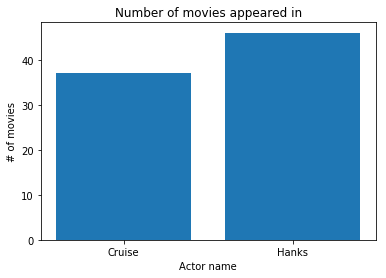

Tom Cruise has appeared in 37 movies.
Tom Hanks has appeared in 46 movies.
Tom Hanks has appeared in 9 more movies than Tom Cruise.


In [33]:
cruise_tot = df_cruise.shape[0]
hanks_tot = df_hanks.shape[0] 

names = ("Cruise", "Hanks")
plt.bar(names,(cruise_tot, hanks_tot))
plt.ylabel("# of movies")
plt.xlabel('Actor name')
plt.title('Number of movies appeared in')

plt.show()
print("Tom Cruise has appeared in "+ str(cruise_tot) + " movies.")
print("Tom Hanks has appeared in "+ str(hanks_tot) + " movies.")
print("Tom Hanks has appeared in "+ str(hanks_tot - cruise_tot) + " more movies than Tom Cruise.")

### 2. Who's the more romantic Tom? (most number/procentage of films with romantic tags)
We can find the romantic films each Tom appeared in by search "Romance" in the column "genres".

In [30]:
def romance_search(df):
    return df[df['genres'].str.contains('Romance')]

romance_search(df_hanks)

,original_title,genres,revenue_adj
3439,Larry Crowne,Comedy|Romance|Drama,3.505380e+07
4179,Forrest Gump,Comedy|Drama|Romance,9.973333e+08
7920,Splash,Comedy|Fantasy|Romance,1.465579e+08
9014,You've Got Mail,Comedy|Romance,3.355228e+08
9450,Big,Fantasy|Drama|Comedy|Romance|Family,2.796607e+08
10010,Joe Versus the Volcano,Fantasy|Comedy|Science Fiction|Romance,6.576171e+07
10240,Sleepless in Seattle,Comedy|Drama|Romance,3.438571e+08
10504,The Money Pit,Comedy|Romance,1.094167e+08
10506,Nothing in Common,Drama|Comedy|Romance,0.000000e+00


In [31]:
romance_search(df_cruise)

,original_title,genres,revenue_adj
2667,Vanilla Sky,Drama|Mystery|Romance|Science Fiction|Thriller,2.504703e+08
4184,Interview with the Vampire,Horror|Romance,3.290356e+08
4438,Rock of Ages,Comedy|Drama|Music|Romance,5.643249e+07
6086,Legend,Action|Adventure|Fantasy|Romance,3.142536e+07
8001,Risky Business,Comedy|Romance,1.391128e+08
8019,All the Right Moves,Romance|Drama,3.772878e+07
8323,Far and Away,Adventure|Drama|Romance|Western,2.141194e+08
8477,Jerry Maguire,Comedy|Drama|Romance,3.802974e+08
9463,Cocktail,Drama|Romance,3.162361e+08
10475,Top Gun,Drama|Action|Romance,7.098811e+08


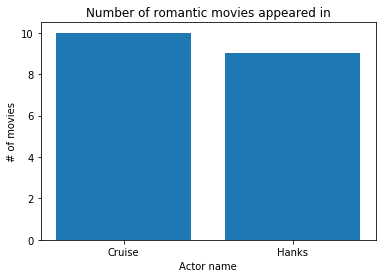

Tom Cruise has appeared in 10 romantic movies.
Tom Hanks has appeared in 9 romantic movies.


In [34]:
cruise_tot_rom = romance_search(df_cruise).shape[0]
hanks_tot_rom = romance_search(df_hanks).shape[0]

cruise_rom_pro = cruise_tot_rom/cruise_tot
hanks_rom_pro = hanks_tot_rom/hanks_tot

plt.bar(names,(cruise_tot_rom, hanks_tot_rom))
plt.title('Number of romantic movies appeared in')
plt.ylabel('# of movies')
plt.xlabel('Actor name')

plt.show()

print("Tom Cruise has appeared in "+ str(cruise_tot_rom) + " romantic movies.")
print("Tom Hanks has appeared in "+ str(hanks_tot_rom) + " romantic movies.")

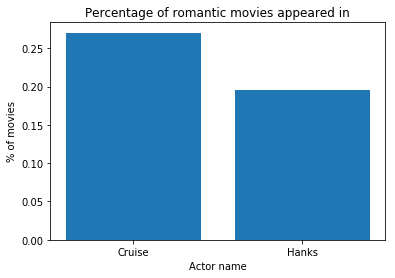

0.27% of the movie Tom Cruise appeared in are romantic movies.
0.2% of the movie Tom hanks appeared in are romantic movies.


In [35]:
plt.bar(names,(cruise_rom_pro, hanks_rom_pro))
plt.title('Percentage of romantic movies appeared in')
plt.ylabel('% of movies')
plt.xlabel('Actor name')
plt.show()

print(str(round(cruise_rom_pro,2)) + "% of the movie Tom Cruise appeared in are romantic movies.")
print(str(round(hanks_rom_pro,2)) + "% of the movie Tom hanks appeared in are romantic movies.")

Tom Cruise has appeared in more romantic movies both in number and in procentage.

### 3. Who's the more bankable Tom? (highest combined & average revenue)

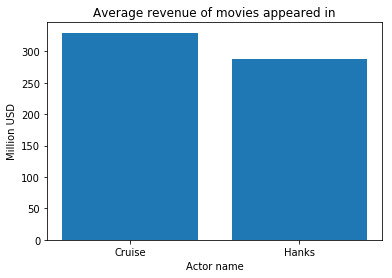

In [36]:
hanks_rev = df_hanks_adj['revenue_adj'].mean()
cruise_rev = df_cruise_adj['revenue_adj'].mean()

plt.bar(names,(cruise_rev/1000000, hanks_rev/1000000))
plt.ylabel("Million USD")
plt.xlabel('Actor name')
plt.title('Average revenue of movies appeared in')
plt.show()

While both actors are box office guarantees, Tom Cruise is the more bankable Tom with over 300 millions USD revenue for each of the films he appeared in. 

<a id='conclusions'></a>
## Conclusions
1. Tom Hanks is the more productive Tom, with 9 films more than Tom Cruise.
2. Tom Cruise is the more romantic Tom, with both higher number and high procentage of his films being in the genre Romance.
3. Tom Cruise is the more bankable Tom. 

## Limitations
1. 76 rows in the initial dataset have no value in the "cast" column, and were therefore dropped and left out of consideration.
2. The initial dataset has 10866 rows/entries. Unlikely that it contains all the films ever made.

From abovementioned two points, it's likely that some films Tom Hanks or Tom Cruise made were left out of consideration, thus, the numbers used in this analysis should not be used as the definitive values on the subject of Tom vs. Tom, rather only as approximations.  

## Submitting your Project 

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [37]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'TMDB_surf.ipynb'])

0